## Methodology per Blair Russell

We may want to rethink the denominator of our equation for housing cost burden.

"Right now it’s all housing units with a cost burden computed. 

Alternatively, you could use low-income households (with cost burden computed) as the denominator, which would be a measure of relative cost burden just for low-income households. 

Both approaches are appropriate, but they tell a different story. You can imagine an area with few low-income households but a vast majority of them being cost burdened. In your calculation, you’d get a small percentage. 

In the alternative approach, it’s a large percentage. Just something to think about. It depends on the story you want to tell."


#### Packages

In [49]:
import math
import numpy as np
import os
import pandas as pd
import requests
import zipfile
from pathlib import Path
import shutil
from cenpy import products

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Table of Contents

Comparisons
*  [Implementation by Lucas](#lucas)
*  [Implementation by Saran](#saran)
*  [Side-by-side Comparison](#comparison)

The relevant denominator variables - all with line type of subtotal - in table 8 of the CHAS dataset are the following (CHAS data dictionary available [here](https://www.huduser.gov/portal/datasets/cp/CHAS-data-dictionary-14-18.xlsx)):

|   Name  |                          Label                      |
|---------|-----------------------------------------------------|
|T1_est3  |      Owner occupied less or equal to 30% of HAMFI   |                                                    | 
|T8_est16 |            Owner occupied greater than 30% of HAMFI cost burden less than 50%           |
|T8_est29 |Owner occupied greater than 50% but less than or equal to 80% of HAMFI	cost burden |
|T8_est69 |Renter occupied less than or equal to 30% of HAMFI|
|T8_est82 |           Renter occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est95 |Renter occupied	greater than 50% but less than or equal to 80% of HAMFI|
 

# ETL - one needs to only run this cell block once to replicate the subsequent notebooks in this draft PR

##### Once run, Table 8 will be in the notebook's current working directory

In [6]:
# Copy and adapt certain sections of code from data_pipeline.utils 

def download_hud_dataset():
    DOWNLOAD_FILENAME = "HUD_ZIPPED.csv"
    HOUSING_FTP_URL = "https://www.huduser.gov/portal/datasets/cp/2014thru2018-140-csv.zip"    
    response = requests.get(HOUSING_FTP_URL, verify=True)
    if response.status_code == 200:
        file_contents = response.content
    else:
        sys.exit(
            f"HTTP response {response.status_code} from url {file_url}. Info: {response.content}"
        )

    # Write the contents to disk.
    file = open(DOWNLOAD_FILENAME, "wb")
    file.write(file_contents)
    file.close()
    
def extract_zipped_download(zip_file_path, unzipped_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(unzipped_path)
    # cleanup temporary file
    os.remove(zip_file_path)
    
def up_one_directory(path):
    try:
        # from Python 3.6
        parent_dir = Path(path).parents[1]
        # for Python 3.4/3.5, use str to convert the path to string
        # parent_dir = str(Path(path).parents[1])
        shutil.move(path, parent_dir)
    except IndexError:
        # no upper directory
        pass

CURRENT_DIRECTORY = os.getcwd()
download_hud_dataset()
extract_zipped_download(CURRENT_DIRECTORY + "/HUD_ZIPPED.csv", CURRENT_DIRECTORY)  
up_one_directory(CURRENT_DIRECTORY + "/140/Table8.csv")
shutil.rmtree("./140/")

### Implementation by Lucas <a id='lucas'></a>

In [3]:
# Read in the data from https://www.huduser.gov/portal/datasets/cp.html
housing = pd.read_csv("Table8.csv", 
                      encoding="latin-1",  
                      dtype = {'Tract_ID': object, 'st': object, 'geoid': object})

# Remove data for states that aren't included in the census (e.g. American Samoa, Guam, etc.):
housing.drop(housing.loc[housing['st'] == '72'].index, inplace = True)

# Rename columns
housing = housing.rename(columns = {'geoid' :'FIPS_tract_id',
                                    'st' : 'state'
                                   })

# Owner occupied numerator fields
OWNER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est7",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est10",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est20",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est23",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est33",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est36",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
OWNER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est13",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est26",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est39",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est52",
    #   Subtotal
    #   Owner occupied
    #   greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est65",
    #   Subtotal
    #   Owner occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

OWNER_OCCUPIED_POPULATION_FIELD = "T8_est2"
#   Subtotal
#   Owner occupied
#   All
#   All
#   All

OWNER_OCCUPIED_POPULATION_HAMFI_FIELD = "T8_est3"
#   Subtotal
#   Owner occupied 
#   All
#   All
#   All

# Renter occupied numerator fields
RENTER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est73",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est76",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est86",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est89",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est99",
    #   Subtotal
    #   Renter occupied	greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est102",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
RENTER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est79",
    #   Subtotal
    #   Renter occupied	less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est92",
    #   Subtotal
    #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est105",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est118",
    #   Subtotal
    #   Renter occupied	greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est131",
    #   Subtotal
    #   Renter occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

# T8_est68	SubtotalRenter occupied	All	All	All
RENTER_OCCUPIED_POPULATION_FIELD = "T8_est68"

In [4]:
# Original computation:
# (
#     # of Owner Occupied Units Meeting Criteria
#     + # of Renter Occupied Units Meeting Criteria
# )
# divided by
# (
#     Total # of Owner Occupied Units
#     + Total # of Renter Occupied Units
#     - # of Owner Occupied Units with HAMFI Not Computed
#     - # of Renter Occupied Units with HAMFI Not Computed
# )

housing["numerator_pre"] = housing[
    OWNER_OCCUPIED_NUMERATOR_FIELDS
].sum(axis=1) + housing[RENTER_OCCUPIED_NUMERATOR_FIELDS].sum(axis=1)



housing["denominator_pre"] = (
    housing[OWNER_OCCUPIED_POPULATION_FIELD]
    + housing[RENTER_OCCUPIED_POPULATION_FIELD]
    - housing[OWNER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
    - housing[RENTER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
)

### Implementation by Saran <a id='saran'></a>

In [5]:
OWNER_REVISED_DENOMINATOR_FIELDS =   [
            # Column Name
            #   Line_Type
            #   Tenure
            #   Household income
            #   Cost burden
            #   Facilities
            "T8_est3",
            #   Subtotal
            #   Renter occupied	less than or equal to 30% of HAMFI
            #   All
            "T8_est16",
            #   Subtotal
            #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
            #   All
            "T8_est29",
            #   Subtotal
            #   Renter occupied
            #   greater than 50% but less than or equal to 80% of HAMFI
            #   All
        ]

RENTAL_REVISED_DENOMINATOR_FIELDS =   [
            # Column Name
            #   Line_Type
            #   Tenure
            #   Household income
            #   Cost burden
            #   Facilities
            "T8_est69",
            #   Subtotal
            #   Renter occupied	less than or equal to 30% of HAMFI
            #   All
            "T8_est82",
            #   Subtotal
            #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
            #   All
            "T8_est95",
            #   Subtotal
            #   Renter occupied
            #   greater than 50% but less than or equal to 80% of HAMFI
            #   All
        ]

# New computation:
# (
#     # of Owner Occupied Units Meeting Criteria
#     + # of Renter Occupied Units Meeting Criteria
# )
# divided by
# (
#     Total # of Owner Occupied Units that meet criterion for poverty
#     + Total # of Renter Occupied Units that meet criterion for poverty
#     - # of Owner Occupied Units with HAMFI Not Computed
#     - # of Renter Occupied Units with HAMFI Not Computed
# )

housing['denominator_post'] = housing[
    RENTAL_REVISED_DENOMINATOR_FIELDS
].sum(axis = 1) + housing[OWNER_REVISED_DENOMINATOR_FIELDS].sum(axis = 1) - (
    - housing[OWNER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
    - housing[RENTER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
)

In [6]:
housing.iloc[:, -3:].head()

,numerator_pre,denominator_pre,denominator_post
0,174,765,295
1,177,720,350
2,279,1291,559
3,274,1635,525
4,885,4135,1090


#### Concatenate GeoIDs with Derived Columns

In [7]:
housing_df = pd.concat([housing.iloc[:, 2: 7], housing.iloc[:, -3:]], axis = 1)

In [8]:
housing_df["ratio_pre"] = np.round(
    housing_df['numerator_pre'] / housing_df['denominator_pre'], 2)

In [9]:
housing_df["ratio_post"] = np.round(
    housing_df['numerator_pre'] / housing_df['denominator_post'], 2)

### Comparison <a id='comparison'></a>

In [10]:
housing_df.head()

,FIPS_tract_id,name,state,cnty,tract,numerator_pre,denominator_pre,denominator_post,ratio_pre,ratio_post
0,14000US01001020100,"Census Tract 201, Autauga County, Alabama",01,1,20100,174,765,295,0.23,0.59
1,14000US01001020200,"Census Tract 202, Autauga County, Alabama",01,1,20200,177,720,350,0.25,0.51
2,14000US01001020300,"Census Tract 203, Autauga County, Alabama",01,1,20300,279,1291,559,0.22,0.50
3,14000US01001020400,"Census Tract 204, Autauga County, Alabama",01,1,20400,274,1635,525,0.17,0.52
4,14000US01001020500,"Census Tract 205, Autauga County, Alabama",01,1,20500,885,4135,1090,0.21,0.81


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

<AxesSubplot:title={'center':'Relative Housing Burden for Low-Income Hosuing Only'}, xlabel='Ratio', ylabel='Frequency'>

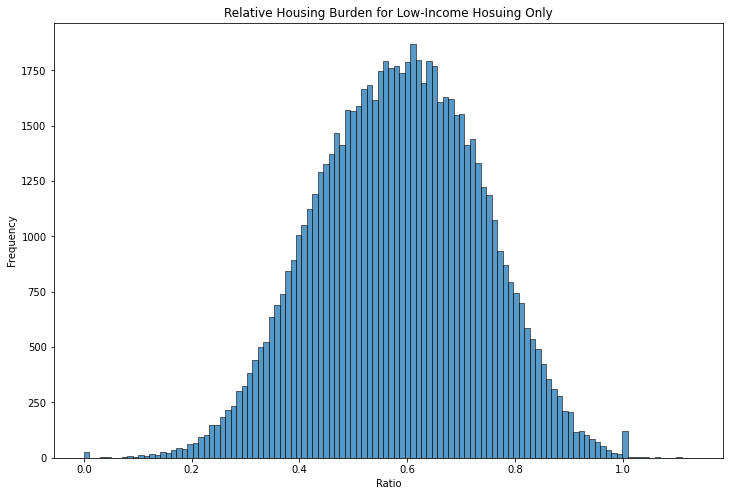

In [12]:
plt.figure(figsize=(12, 8))
plt.title('Relative Housing Burden for Low-Income Hosuing Only')
# Set x-axis label
plt.xlabel('Ratio')
# Set y-axis label
plt.ylabel('Frequency')

sns.histplot(housing_df["ratio_post"])

<AxesSubplot:title={'center':'Housing Burden Relative to All Owned and Rented Housing (Currently used in Score L)'}, xlabel='Ratio (prior to conversion to percent)', ylabel='Frequency'>

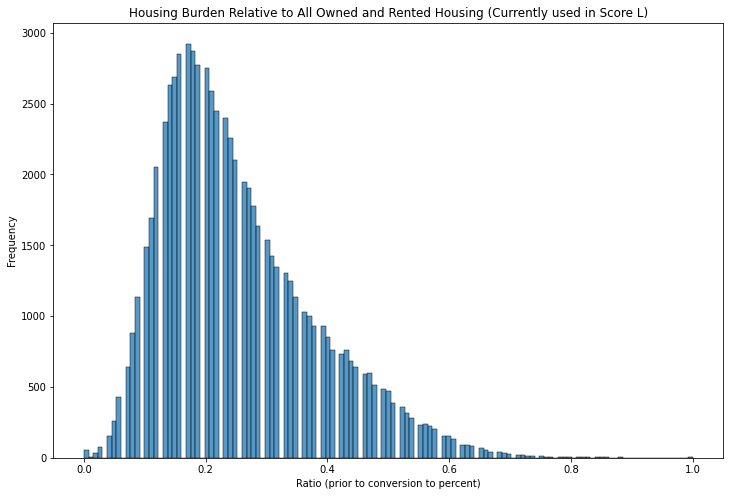

In [42]:
plt.figure(figsize=(12, 8))
plt.title('Housing Burden Relative to All Owned and Rented Housing (Currently used in Score L)')
# Set x-axis label
plt.xlabel('Ratio (prior to conversion to percent)')
# Set y-axis label
plt.ylabel('Frequency')

sns.histplot(housing_df["ratio_pre"])

In [15]:
housing_df[housing_df["ratio_post"] > 1][['name', "FIPS_tract_id",  "ratio_pre", 'ratio_post']]

,name,FIPS_tract_id,ratio_pre,ratio_post
4203,"Census Tract 3923, Contra Costa County, Califo...",14000US06013392300,0.20,1.01
4617,"Census Tract 38.06, Kern County, California",14000US06029003806,0.10,1.03
5262,"Census Tract 2060.20, Los Angeles County, Cali...",14000US06037206020,0.26,1.07
5565,"Census Tract 2626.01, Los Angeles County, Cali...",14000US06037262601,0.07,1.06
12908,"Census Tract 303, Fairfield County, Connecticut",14000US09001030300,0.09,1.04
14086,"Census Tract 102, District of Columbia, Distri...",14000US11001010200,0.15,1.02
17668,"Census Tract 273.23, Pinellas County, Florida",14000US12103027323,0.18,1.02
18102,"Census Tract 208.10, Seminole County, Florida",14000US12117020810,0.14,1.03
19796,"Census Tract 101.02, Liberty County, Georgia",14000US13179010102,0.33,1.06
21166,"Census Tract 507, Cook County, Illinois",14000US17031050700,0.16,1.03


In [51]:
census_acs_2019 = pd.read_csv("../data/dataset/census_acs_2019/usa.csv")
# urban--rural
geo_corr = pd.read_csv("../data/dataset/geocorr/usa.csv")

In [52]:
merge_1 = census_acs_2019.merge(geo_corr, 
                                on = "GEOID10_TRACT", 
                               )

In [53]:
# these are not converted into percent 0 - 100 scale
percent_cols = [x for x in merge_1.columns if 
                'Percent' in x or '(percent)' in x
    ]

merge_1[
    percent_cols] = merge_1[
    percent_cols].apply(lambda x: x * 100)

In [54]:
merge_1.head()

,GEOID10_TRACT,Unemployed civilians (percent),Linguistic isolation (percent),Median household income in the past 12 months,Percent of individuals < 100% Federal Poverty Line,Percent of individuals < 150% Federal Poverty Line,Percent of individuals < 200% Federal Poverty Line,Median value ($) of owner-occupied housing units,Percent individuals age 25 or over with less than high school degree,Percent enrollment in college or graduate school,...,Percent Asian alone,Percent Native Hawaiian and Other Pacific alone,Percent Two or more races,Percent Non-Hispanic White,Percent Hispanic or Latino,population_in_rural_areas,population_in_urban_areas,perc_population_in_rural_areas,perc_population_in_urban_areas,Urban Heuristic Flag
0,1073001100,0.920716,0.000000,37030,15.037594,31.879699,37.443609,85500,8.219178,8.907519,...,0.0,0.0,0.000000,1.610542,0.355574,NaN,5355.0,NaN,1.0,1
1,1073001400,11.501211,2.450980,36066,28.160329,36.793422,48.355601,67800,17.425432,7.715491,...,0.0,0.0,0.359712,0.000000,6.834532,NaN,2181.0,NaN,1.0,1
2,1073002000,13.754853,1.973221,27159,51.335163,61.617170,72.797604,68400,23.340471,6.393392,...,0.0,0.0,0.931373,27.745098,7.500000,NaN,3885.0,NaN,1.0,1
3,1073003802,10.333193,0.000000,38721,19.656020,34.038934,52.901153,64100,14.318707,8.355030,...,0.0,0.0,0.850501,1.606502,0.000000,NaN,5409.0,NaN,1.0,1
4,1073004000,21.148325,4.478656,18525,40.584287,58.507698,70.785630,67300,17.047184,3.975265,...,0.0,0.0,4.500592,6.592973,6.829846,NaN,3772.0,NaN,1.0,1


In [22]:
sample = housing_df[housing_df["ratio_post"] > 1][['name', "FIPS_tract_id",  "ratio_pre", 'ratio_post']]

In [26]:
sample["FIPS_tract_id"] = sample["FIPS_tract_id"].str.replace(r"^.*?US", "", regex=True)

In [28]:
sample["FIPS_tract_id"] = sample["FIPS_tract_id"].astype(np.int64)

In [39]:
subset.dtypes

name                                                                     object
FIPS_tract_id                                                             int64
Percent of individuals < 200% Federal Poverty Line                      float64
Median value ($) of owner-occupied housing units                          int64
Percent individuals age 25 or over with less than high school degree    float64
Percent enrollment in college or graduate school                        float64
Percent Black or African American alone                                 float64
Percent Non-Hispanic White                                              float64
Percent Hispanic or Latino                                              float64
dtype: object

In [55]:
final_sample_df = sample.merge(merge_1,
                               left_on = "FIPS_tract_id", 
                               right_on = "GEOID10_TRACT")

In [56]:
subset = final_sample_df[[ 'name',
        'FIPS_tract_id',
       'Percent of individuals < 200% Federal Poverty Line',
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school',
       'Percent Black or African American alone',
        'Percent Non-Hispanic White',
       'Percent Hispanic or Latino'
]]

### Key Takeaways from the 20 tracts with greater than 100%

1. Current college enrollment is not prevalent across all tracts
2. The results make sense - given the median value (USD) of an owned propert any individual, relative to all other low-income housholds (regardless if owned and rented). These may be areas of gentrification, for example. Further analysis through time may be pertinent as a follow-up (below)

In [43]:
subset

,name,FIPS_tract_id,Percent of individuals < 200% Federal Poverty Line,Median value ($) of owner-occupied housing units,Percent individuals age 25 or over with less than high school degree,Percent enrollment in college or graduate school,Percent Black or African American alone,Percent Non-Hispanic White,Percent Hispanic or Latino
0,"Census Tract 3923, Contra Costa County, Califo...",6013392300,15.962892,745200,9.870849,12.832370,16.122841,8.029431,7.869482
1,"Census Tract 38.06, Kern County, California",6029003806,16.663441,352900,5.372263,13.191794,3.754596,53.686859,27.482098
2,"Census Tract 2060.20, Los Angeles County, Cali...",6037206020,18.998273,465600,33.618813,2.203333,31.809545,18.520174,43.187661
3,"Census Tract 2626.01, Los Angeles County, Cali...",6037262601,3.277762,1962000,2.110514,5.596621,1.299802,71.263069,5.651314
4,"Census Tract 303, Fairfield County, Connecticut",9001030300,1.888112,2000001,0.413534,5.141388,0.932401,93.216783,1.911422
5,"Census Tract 102, District of Columbia, Distri...",11001010200,12.548369,752800,1.782304,12.584733,23.535851,55.117679,8.155446
6,"Census Tract 273.23, Pinellas County, Florida",12103027323,16.731243,424600,4.211060,8.011745,6.140351,79.298246,6.947368
7,"Census Tract 208.10, Seminole County, Florida",12117020810,13.399578,270300,4.645270,4.929322,4.561717,68.127609,14.400716
8,"Census Tract 101.02, Liberty County, Georgia",13179010102,29.349112,217100,0.000000,1.984564,18.086081,58.836996,16.483516
9,"Census Tract 507, Cook County, Illinois",17031050700,9.242250,535100,2.570694,6.017831,0.516648,91.618829,3.731343


In [90]:
import cenpy
import segregation
import contextily as ctx
import xyzservices.providers as xyz
%matplotlib inline

acs = cenpy.products.ACS(2019)

In [91]:
acs.variables

,label,concept,predicateType,group,limit,predicateOnly,attributes,required
AIANHH,Geography,NaN,NaN,N/A,0,NaN,NaN,NaN
AIHHTL,Geography,NaN,NaN,N/A,0,NaN,NaN,NaN
AIRES,Geography,NaN,NaN,N/A,0,NaN,NaN,NaN
ANRC,Geography,NaN,NaN,N/A,0,NaN,NaN,NaN
B01001A_001E,Estimate!!Total:,SEX BY AGE (WHITE ALONE),int,B01001A,0,NaN,"B01001A_001EA,B01001A_001M,B01001A_001MA",NaN
...,...,...,...,...,...,...,...,...
UA,Geography,NaN,NaN,N/A,0,NaN,NaN,NaN
ZCTA,Geography,NaN,NaN,N/A,0,NaN,NaN,NaN
for,Census API FIPS 'for' clause,Census API Geography Specification,fips-for,N/A,0,True,NaN,NaN
in,Census API FIPS 'in' clause,Census API Geography Specification,fips-in,N/A,0,True,NaN,NaN


In [92]:
acs.tables

,description,columns
table_name,,
B01001,SEX BY AGE,"[B01001_001E, B01001_002E, B01001_003E, B01001..."
B01002,MEDIAN AGE BY SEX,"[B01002_001E, B01002_002E, B01002_003E]"
B01003,TOTAL POPULATION,[B01003_001E]
B02001,RACE,"[B02001_001E, B02001_002E, B02001_003E, B02001..."
B02008,WHITE ALONE OR IN COMBINATION WITH ONE OR MORE...,[B02008_001E]
...,...,...
C27014,PUBLIC HEALTH INSURANCE BY WORK EXPERIENCE,"[C27014_001E, C27014_002E, C27014_003E, C27014..."
C27016,HEALTH INSURANCE COVERAGE STATUS BY RATIO OF I...,"[C27016_001E, C27016_002E, C27016_003E, C27016..."
C27017,PRIVATE HEALTH INSURANCE BY RATIO OF INCOME TO...,"[C27017_001E, C27017_002E, C27017_003E, C27017..."


In [93]:
acs.filter_tables('HISPANIC', by='description')


,description,columns
table_name,,
B03001,HISPANIC OR LATINO ORIGIN BY SPECIFIC ORIGIN,"[B03001_001E, B03001_002E, B03001_003E, B03001..."
B03002,HISPANIC OR LATINO ORIGIN BY RACE,"[B03002_001E, B03002_002E, B03002_003E, B03002..."
B03003,HISPANIC OR LATINO ORIGIN,"[B03003_001E, B03003_002E, B03003_003E]"
B16006,LANGUAGE SPOKEN AT HOME BY ABILITY TO SPEAK EN...,"[B16006_001E, B16006_002E, B16006_003E, B16006..."
B98013,TOTAL POPULATION COVERAGE RATE BY WEIGHTING RA...,"[B98013_001E, B98013_002E, B98013_003E, B98013..."
B99031,ALLOCATION OF HISPANIC OR LATINO ORIGIN,"[B99031_001E, B99031_002E, B99031_003E]"


In [65]:
acs.filter_variables('B03002')

,label,concept,predicateType,group,limit,predicateOnly,attributes,required,values
B03002_021E,Estimate!!Total!!Hispanic or Latino!!Two or mo...,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_021EA,B03002_021M,B03002_021MA",NaN,NaN
B03002_020E,Estimate!!Total!!Hispanic or Latino!!Two or mo...,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_020EA,B03002_020M,B03002_020MA",NaN,NaN
B03002_001E,Estimate!!Total,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_001EA,B03002_001M,B03002_001MA",NaN,NaN
B03002_005E,Estimate!!Total!!Not Hispanic or Latino!!Ameri...,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_005EA,B03002_005M,B03002_005MA",NaN,NaN
B03002_004E,Estimate!!Total!!Not Hispanic or Latino!!Black...,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_004EA,B03002_004M,B03002_004MA",NaN,NaN
B03002_003E,Estimate!!Total!!Not Hispanic or Latino!!White...,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_003EA,B03002_003M,B03002_003MA",NaN,NaN
B03002_002E,Estimate!!Total!!Not Hispanic or Latino,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_002EA,B03002_002M,B03002_002MA",NaN,NaN
B03002_009E,Estimate!!Total!!Not Hispanic or Latino!!Two o...,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_009EA,B03002_009M,B03002_009MA",NaN,NaN
B03002_007E,Estimate!!Total!!Not Hispanic or Latino!!Nativ...,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_007EA,B03002_007M,B03002_007MA",NaN,NaN
B03002_008E,Estimate!!Total!!Not Hispanic or Latino!!Some ...,HISPANIC OR LATINO ORIGIN BY RACE,int,B03002,0,NaN,"B03002_008EA,B03002_008M,B03002_008MA",NaN,NaN


In [66]:
hispanic = ['B03002_001', # full population 
            'B03002_002', # nonhispanic
            'B03002_012' # hispanic 
           ]

In [68]:
# Travis County, Texas - ie Austin, TX
travis = acs.from_place('Austin, TX', variables=hispanic)


Matched: Austin, TX to Austin city within layer Incorporated Places


In [73]:
# plot percentage of hispanic population
austin_basemap, austin_extent = ctx.bounds2img(*travis.total_bounds, zoom=10, 
                               )

<AxesSubplot:>

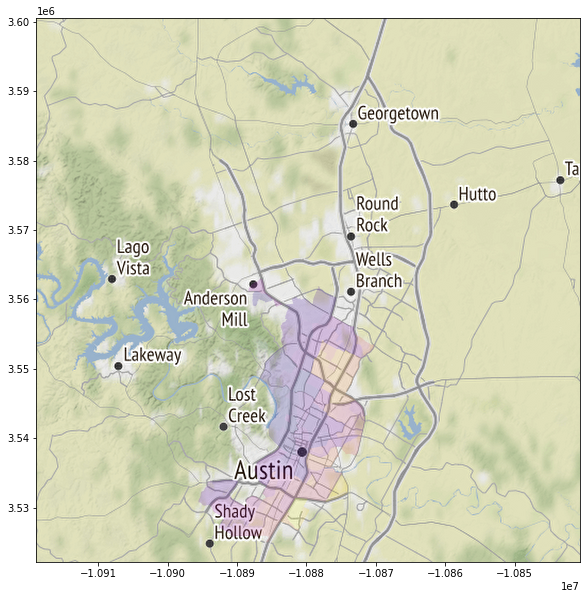

In [79]:
f,ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(austin_basemap, extent=austin_extent, interpolation='sinc')
travis['pct_hispanic'] = travis.eval('B03002_012E / B03002_001E')
travis.plot('pct_hispanic', cmap='plasma', ax = ax, alpha=.2)

### Estimating segregation 

To compute segregation in Austin for the 2019 five-year ACS, 
the segregation package takes the dataframe and column names containing the
group under study and the total population. For this, you can estimate the
Massey-Denton Dissimilarity statistic

In [80]:
seg_travis = segregation.aspatial.Dissim(travis, 
                                          group_pop_var='B03002_012E', 
                                          total_pop_var='B03002_001E')

In [82]:
seg_travis.statistic

0.4217538409159379

In [86]:
seg_travis.core_data.head()

,group_pop_var,total_pop_var,geometry
0,1155.0,6839.0,"POLYGON ((-10895569.270 3530806.490, -10895537..."
1,1010.0,6507.0,"POLYGON ((-10894266.830 3533308.740, -10894263..."
2,1476.0,4650.0,"POLYGON ((-10891755.130 3528693.690, -10891525..."
3,2047.0,5705.0,"POLYGON ((-10889272.370 3525921.290, -10889122..."
4,2250.0,5446.0,"POLYGON ((-10885758.680 3533118.060, -10885748..."


While this computes the dissimilarity metric, it does not conduct inference 
on that value. segregation has a generic testing framework, segregation.inference, 
that can estimate and re-estimate segregation indices under certain assumptions. 

# Comparing across time

In [94]:
austin_2013 = cenpy.products.ACS(2013).from_place('Austin, TX', variables=hispanic)
austin_2013['pct_hispanic'] = austin_2013.eval('B03002_012E / B03002_001E')

Matched: Austin, TX to Austin city within layer Incorporated Places


Compare the spatial distributions visually:

Text(0.5, 1.0, 'Relative Change')

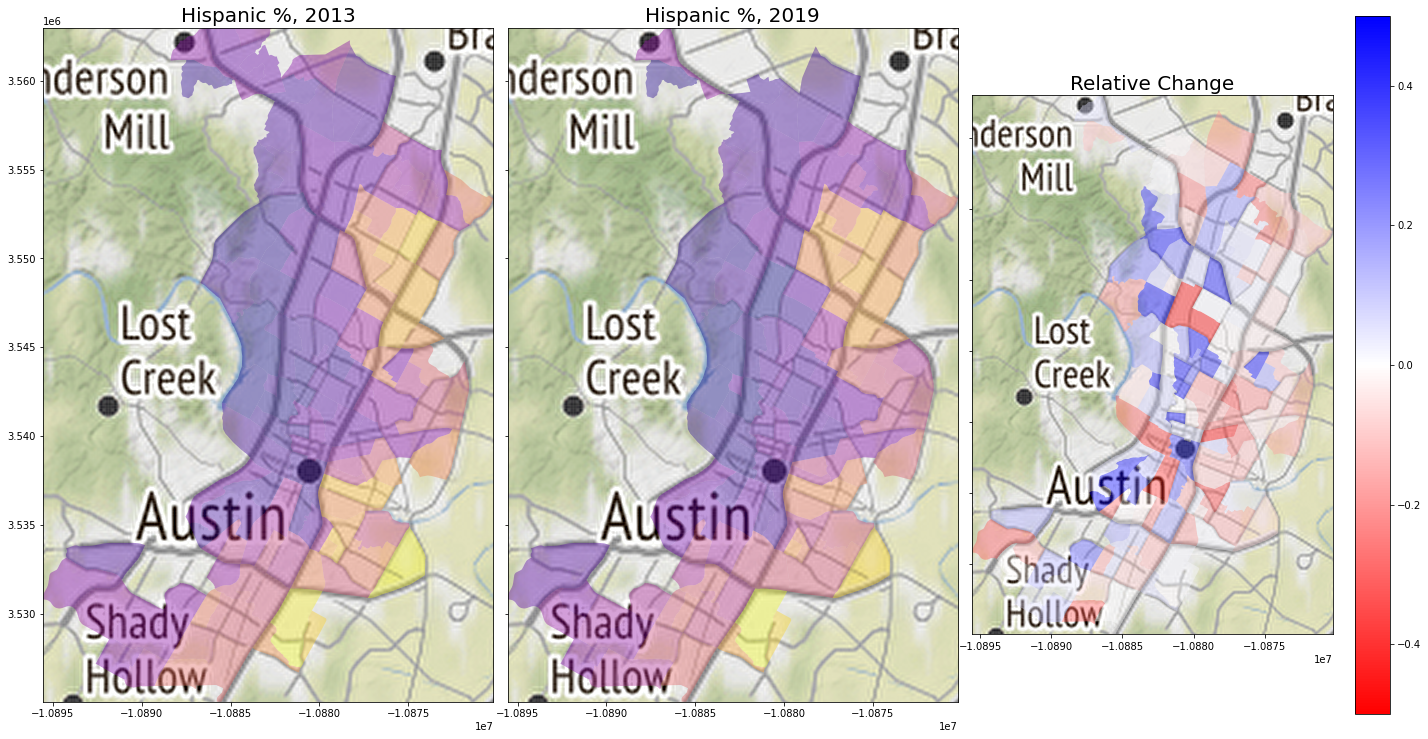

In [98]:
f,ax = plt.subplots(1,3, figsize=(20,10), sharex=True, sharey=True)
[ax_.imshow(austin_basemap, extent=austin_extent, interpolation='sinc') for ax_ in ax]
travis.plot('pct_hispanic', cmap='plasma', ax = ax[1], alpha=.4)
austin_2013.plot('pct_hispanic', cmap='plasma', ax = ax[0], alpha=.4)
travis.merge(austin_2013.drop('geometry',axis=1), on='GEOID', suffixes=('_2019', '_2013'))\
       .eval('pct_change = (pct_hispanic_2019 - pct_hispanic_2013)/(pct_hispanic_2013)')\
       .plot('pct_change', cmap='bwr_r', ax=ax[2], alpha=.4, vmin=-.5, vmax=.5, legend=True)
f.tight_layout()
ax[0].axis(travis.total_bounds[[0,2,1,3]])
ax[0].set_title('Hispanic %, 2013', fontsize=20)
ax[1].set_title('Hispanic %, 2019', fontsize=20)
ax[2].set_title('Relative Change', fontsize=20)

In [99]:
seg_austin_2013 = segregation.aspatial.Dissim(austin_2013, 
                                              group_pop_var='B03002_012E', 
                                              total_pop_var='B03002_001E')

In [101]:
seg_austin_2013.statistic

0.44248673415326

In [102]:
time_comparison = segregation.inference.TwoValueTest(seg_travis, seg_austin_2013)

AttributeError: 'Dissim' object has no attribute 'data'